In [121]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

def linear(x, slope, intercept):
    return slope*x + intercept

def logit(p):
    return np.log(p/(1-p))

def inv_logit(alpha):
    return np.exp(alpha)/(np.exp(alpha)+1)

def logistic(x, beta_0, beta_1):
    return inv_logit(linear(x, beta_0, beta_1))



In [189]:
# Linear Regression example
model = logistic
param_count = 2
step_size = 2**-8
differential_length = 2**-16
epoch_count = 2**10

def squared_error(params, x, y):
    squared_error = (model(x, *params) - y)**2
    return squared_error

def surprisal(params, x, y):
    prob = model(x, *params)
    if y:
        return -np.log(prob)
    else:
        return -np.log(1-prob)


loss = surprisal

xdata = np.array([5, 8, 7, 3, 6, 4, 1, 9])
ydata = [1, 1, 1, 0, 1, 0, 0, 1]

In [183]:
def descent_step(params, x, y, weight):
    gradient = np.zeros(param_count)
    for i in range(param_count):
        d = np.zeros(param_count)
        d[i] = differential_length
        directional_derivative = (loss(params+d, x, y) - loss(params, x, y))/differential_length
        gradient[i] = directional_derivative
    params = params - weight*gradient*step_size
    return params


def epoch(params, xdata, ydata, weights):
    for i in range(len(xdata)):
        params = descent_step(params, xdata[i], ydata[i], weights[i])
    return params

def gradient_descent(params, xdata, ydata, weights):
    for _ in range(epoch_count):
        params = epoch(params, xdata, ydata, weights)
    return params

This function calculates the parameters which result from retraining with an additional datapoint *new* that is weighted by some amount *epsilon*.

In [184]:
# Influence functions are defined as the first-order Taylor approximation of this around epsilon = 0
# Or maybe the derivative if it's more convenient to subtract off the value at 0, I think I've seen both definitions
def response_function(new_data, epsilon, xdata, ydata):
    newxdata = np.concatenate((np.array([new_data[0]]), xdata))
    newydata = np.concatenate((np.array([new_data[1]]), ydata))
    weights = np.array([epsilon] + [1 for _ in xdata])
    params = gradient_descent(np.zeros(param_count), newxdata, newydata, weights)
    return params

Initial model: [ 0.72570523 -2.73020194]
Influence of (0, 0) on theta: [nan nan]


C:\Users\april\AppData\Local\Temp\ipykernel_8692\550464618.py:6: RuntimeWarning: invalid value encountered in divide
  print(f'Influence of {z} on theta: {(x-y)/(epsilon)}')


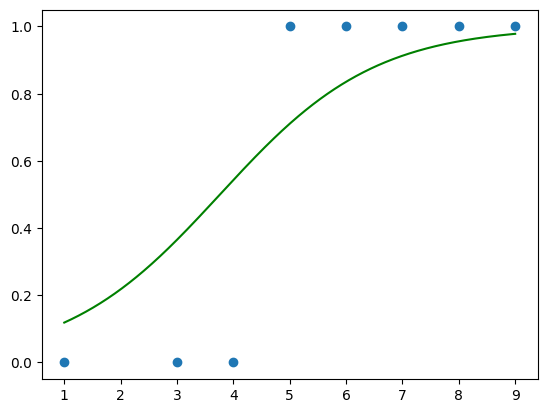

In [191]:
epsilon = 0
z = (0,0)
x = response_function(z, epsilon, xdata, ydata)
y = response_function(z, 0, xdata, ydata)
print(f'Initial model: {y}')
print(f'Influence of {z} on theta: {(x-y)/(epsilon)}')
linspace = np.linspace(xdata.min(), xdata.max(), 500)

plt.plot(linspace, model(linspace, *y), color='green')
plt.scatter(xdata,ydata)
plt.show()

This looks at each data point in the training data, and computes how much changing its weight impacts the cost function. It then sorts the data points by how much increasing their weight decreases the cost function.

In [ ]:
def order_by_cost_influence(epsilon, func, xdata, ydata, cost):
    influences = []
    for i in range(len(xdata)):
        params0 = response_function((xdata[i],ydata[i]), 0, func, xdata, ydata)
        params1 = response_function((xdata[i],ydata[i]), epsilon, func, xdata, ydata)
        cost0 = cost(func, params0, xdata, ydata)
        cost1 = cost(func, params1, xdata, ydata)
        influences += [(cost1 - cost0)/epsilon]
    data = [((xdata[i], ydata[i]), influences[i]) for i in range(len(xdata))]
    return sorted(data, key = lambda x: x[1])

In [ ]:
model = linear

print(order_by_cost_influence(1, model, xdata, ydata, cost))
print(order_by_cost_influence(0.1, model, xdata, ydata, cost))
print(order_by_cost_influence(0.01, model, xdata, ydata, cost))
print(order_by_cost_influence(0.001, model, xdata, ydata, cost))

[((0, 0.0), -0.09090909090928878), ((2, 2.0), -0.09090909090928845), ((1, 1.5), 0.2500000000054533)]
[((0, 0.0), -0.016528925867196342), ((2, 2.0), -0.016528925865653132), ((1, 1.5), 0.033222536090563026)]
[((2, 2.0), -0.0016665277831173775), ((0, 0.0), -0.0016665277830840708), ((1, 1.5), 0.003333222236845401)]
[((2, 2.0), -0.00016666652513652735), ((0, 0.0), -0.00016666652469243814), ((1, 1.5), 0.00033147602693239797)]
